# Robust Principal Component Analysis 
Classifying faces.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.image import imread

import os
import scipy.io

In [2]:
## set plotting paramenters as default for the rest of the notebook
plt.rcParams["figure.figsize"] = [10,4]
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rcParams.update({'legend.fontsize': 11})
plt.rcParams.update({'axes.labelsize': 15})
plt.rcParams.update({'font.size': 15})

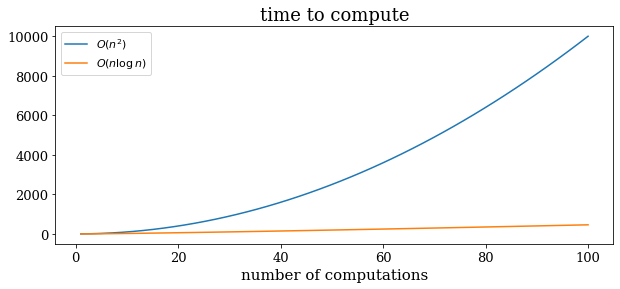

In [3]:
# play with O(n^2) and O(n*log(n))
# Quick refresher that the DFT and FFT scale with O(n^2) and O(n*log(n)), respectively
nf = np.linspace(1,100)

plt.plot(nf, nf**2, label=r"$O(n^2)$")
plt.plot(nf, nf*np.log(nf), label=r"$O(n \log{n})$")
plt.xlabel("number of computations")
plt.title("time to compute")
plt.legend()

Understand $O(n^2)$ vs $O(n \log{n})$ time complexity

## Eigenfaces 
Import the **.mat faces dataset, then span an eigenface space and use it to classify poeple and also use it to represent another pictures, e.g. al botoncito.** Find the PCA using:

\begin{align*}
{\bf B} &= {\bf X - \bar{X}} \\
\rightarrow {\bf B} &= {\bf U\Sigma V^*} 
\end{align*}

In [4]:
mat_contents = scipy.io.loadmat(os.path.join('/', "home", "igodlab", "Documents", "DataDriven", "DATA", 'allFaces.mat'))  ## loads the **.mat file as a Python dictionary
faces = mat_contents['faces'] ## images of faces (each of them is flattened)
m = int(mat_contents['m'])  ## actual shape of each image
n = int(mat_contents['n'])  ## actual shape of each image
ntot = int(mat_contents["person"]) ## total #of people = 38
nfaces = mat_contents["nfaces"][0]  ## #of pictures for the same person, total=38 people

print("'faces' matrix contains pictures as the columns. Every person has 59 to 64 different \
         pictures so the total number of columns is the sum of 'nfaces' vector")

'faces' matrix contains pictures as the columns. Every person has 59 to 64 different          pictures so the total number of columns is the sum of 'nfaces' vector


In [9]:
faces.shape

(32256, 2410)

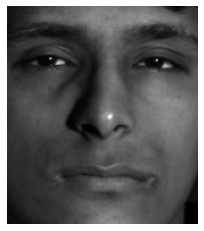

In [5]:
## example plot one of the faces
nper = 34 ## #of person
npic = 44
ith = sum(nfaces[:nper-1])+(npic-1) ## 44-th picture of person: nper=34
ith_face = np.reshape(faces[:,ith], (m,n)).T  ## reshape and transpose to get the rigth format
plt.imshow(ith_face)
plt.axis("off")
plt.set_cmap("gray")
plt.show()

In [6]:
## compute the eigenface space
nper_train = int(0.95*len(nfaces))
ntrain = sum(nfaces[:nper_train])
Xtrain = faces[:, :ntrain]  ## training set
avg_face = np.tile(np.mean(Xtrain, axis=1), (np.shape(Xtrain)[1], 1)).T  

B = Xtrain - avg_face
U, S, VT = np.linalg.svd(B, full_matrices=False)

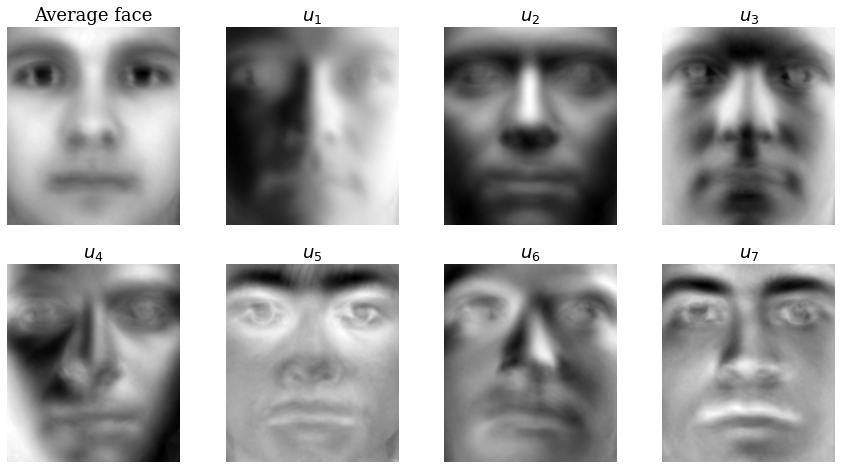

In [7]:
## plot the average face and the first 7 modes
fig, axes = plt.subplots(2,4,figsize=(15,8))
for i in range(4):
    if i == 0:
        axes[0,0].imshow(np.reshape(avg_face[:,0], (m,n)).T)
        axes[0,0].set_title("Average face")
        axes[0,0].axis("off")
    else:
        axes[0,i].imshow(np.reshape(U[:,i], (m,n)).T)
        axes[0,i].set_title(r"$u_{:.0g}$".format(i))
        axes[0,i].axis("off")
    
    axes[1,i].imshow(np.reshape(U[:,i+4], (m,n)).T)
    axes[1,i].set_title(r"$u_{:.0g}$".format(i+4))
    axes[1,i].axis("off")

In [13]:
## import this function for case (iii) from github, same authors of the paper referenced
from OptHT import optht

In [14]:
### optimal hard thereshold, method 3
#gamma = 1
beta = np.shape(B)[1]/np.shape(B)[0]
lmbda = (2*(beta+1)+8*beta/((beta+1)+(beta**2+14*beta+1)**(1/2)))**(1/2)
#tau = lmbda*np.sqrt(np.shape(faces)[0])*gamma
r_opt = optht(beta, S)

Sigma unknown:
*************
approximated coefficent w(beta):  1.5542021541111426
optimal coefficent w(beta):  1.557801113863529
cutoff value:  1264.0306430252326
target rank:  766


In [15]:
tau = 1264.0306430252317  ## define the cutoff value

Text(0.5, 0, '$r$')

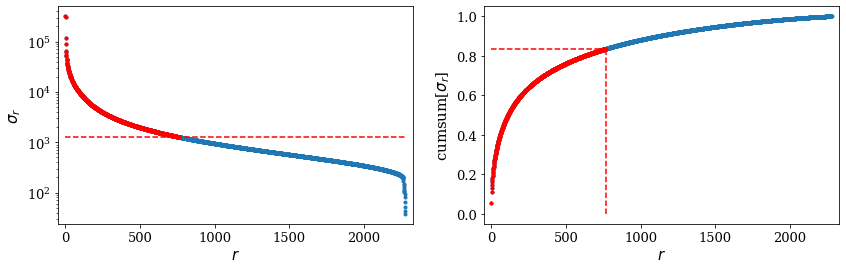

In [16]:
r = len(S)-1 ## use total number -1 because is extremly small

## plot
plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
plt.semilogy(S[:r],'.')
plt.hlines(tau, 0, r, linestyle="--", color="r")
plt.semilogy(S[:r_opt], "r.")
plt.xlim(0.0-50, r+50)

plt.ylabel(r"$\sigma_r$")
plt.xlabel(r"$r$")

plt.subplot(1,2,2)
plt.plot(np.cumsum(S[:r])/sum(S[:r]), ".")
plt.plot(np.cumsum(S[:r_opt])/sum(S[:r]), "r.")
plt.vlines(r_opt, 0, sum(S[:r_opt])/sum(S[:r]), linestyle="--", color="r")
plt.hlines(sum(S[:r_opt])/sum(S[:r]), 0.0, r_opt, linestyle="--", color="r")
plt.xlim(0.0-50, r+50)
plt.ylabel(r"cumsum[$\sigma_r$]")
plt.xlabel(r"$r$")

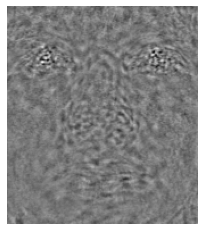

In [17]:
## show noisy eigenface-space U's
n_ht = 800
plt.imshow(np.reshape(U[:,n_ht], (m,n)).T)
plt.axis("off")
plt.show()

Example of an eigenface (PCA) past the threshold, in this case number 800

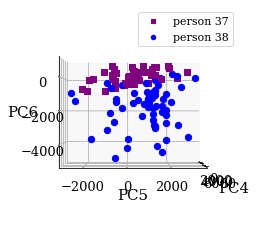

In [10]:
## built classifier prototype
Xtest = faces[:,ntrain:] ## collection set of faces for the two people of the test set

## plot
fig2 = plt.figure()
axes = fig2.add_subplot(111, projection='3d')

pcax = [3,4, 5] ## 3 PCA axis
for j in range(np.shape(Xtest)[1]):
    x = U[:,pcax[0]].T @ Xtest[:,j]
    y = U[:,pcax[1]].T @ Xtest[:,j]
    z = U[:,pcax[2]].T @ Xtest[:,j]
    if (j >= 0) and (j < nfaces[nper_train]):
        axes.scatter(x,y,z, marker="s", color="purple", s=40)
    else:
        axes.scatter(x,y,z, marker="o", color="b", s=40)   

axes.view_init(elev=0, azim=0)  ## fix the 3D view
axes.scatter([], [], [], marker='s',color='purple', label="person 37")
axes.scatter([], [], [], marker='o',color='b', label="person 38")
axes.set_xlabel("PC"+str(pcax[0]+1))
axes.set_ylabel("PC"+str(pcax[1]+1))
axes.set_zlabel("PC"+str(pcax[2]+1))
axes.legend()

In [12]:
U.T.shape

(2282, 32256)